# Library Imports

In [1]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from time import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset
import torch.nn.utils.weight_norm as WN
import torch.nn.functional as F

import random as r

import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Helper Functions

In [2]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def preprocess(x):
  df = x.copy()
  df.iloc[:, 1] = df.iloc[:, 1].map({"trt_cp" : 0, "ctl_vehicle" : 1})
  df.iloc[:, 3] = df.iloc[:, 3].map({"D1" : 0, "D2" : 1})
  return df

def getCol(x):
  return [col for col in x.columns]

n_folds = 4

# Data Handling

**Inputs**

In [3]:
tr_feat = pd.read_csv('../input/lish-moa/train_features.csv')
tr_lbls = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
ts_feat = pd.read_csv('../input/lish-moa/test_features.csv')

breaker()
print("TRAINING FEATURES DATASET SHAPE :", repr(tr_feat.shape))
breaker()
print("TRAINING LABELS DATASET SHAPE   :", repr(tr_lbls.shape))
breaker()
print("TEST FEATURES DATASET SHAPE     :", repr(ts_feat.shape))
breaker()

X = tr_feat.copy()
y = tr_lbls.copy()


------------------------------

TRAINING FEATURES DATASET SHAPE : (23814, 876)

------------------------------

TRAINING LABELS DATASET SHAPE   : (23814, 207)

------------------------------

TEST FEATURES DATASET SHAPE     : (3982, 876)

------------------------------



**Top Features**

In [4]:
top_feats = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
              18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
              32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
              47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
              61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
              74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
              89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
              102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
              115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
              129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
              144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
              158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
              171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
              184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
              198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
              213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
              227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
              240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
              254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
              267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
              281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
              295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
              310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
              324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
              337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
              350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
              363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
              378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
              392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
              405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
              419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
              432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
              447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
              463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
              476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
              490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
              506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
              522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
              538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
              552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
              571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
              586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
              600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
              618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
              631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
              645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
              660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
              673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
              686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
              701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
              718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
              733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
              748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
              762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
              775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
              789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
              804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
              821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
              837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
              854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
              870, 871, 872, 873, 874]

num_features = len(top_feats)
num_classes  = tr_lbls.shape[1] - 1
num_obs_test = ts_feat.shape[0]
columns      = getCol(tr_lbls)

del tr_feat, tr_lbls

**Dataset Template**

In [5]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y

  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [6]:
class ANN_CFG():
    tr_batch_size = 256
    va_batch_size = 256
    ts_batch_size = 256
    
    epochs = 50
    
    IL = num_features
    HL = [512, 512, 512]
    OL = num_classes
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
cfg = ANN_CFG()

**Setup**

In [7]:
class ANN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(ANN, this).__init__()
        
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)
        
        this.BN1 = nn.BatchNorm1d(IL)
        this.FC1 = WN(nn.Linear(IL, HL[0]))
        
        this.BN2 = nn.BatchNorm1d(HL[0])
        this.FC2 = WN(nn.Linear(HL[0], HL[1]))
        
        this.BN3 = nn.BatchNorm1d(HL[1])
        this.FC3 = WN(nn.Linear(HL[1], HL[2]))
        
        this.BN4 = nn.BatchNorm1d(HL[2])
        this.FC4 = WN(nn.Linear(HL[2], OL))
    
    
    def getOptimizer(this):
        return optim.Adam(this.parameters(), lr=1e-3, weight_decay=1e-5)
    
    def forward(this, x):
        x = this.BN1(x)
        x = this.DP1(x)
        x = F.relu(this.FC1(x))
        
        x = this.BN2(x)
        x = this.DP2(x)
        x = F.relu(this.FC2(x))
        
        x = this.BN3(x)
        x = this.DP2(x)
        x = F.relu(this.FC3(x))
        
        x = this.BN4(x)
        x = this.DP2(x)
        x = torch.sigmoid(this.FC4(x))
        return x

**ANN Helpers**

In [8]:
def train_fn(X=None, y=None, n_folds=None):
    breaker()
    print("Training ...")
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    name_getter = []
    LP = []
    fold = 0
    
    X = preprocess(X)
    
    breaker()
    start_time = time()
    for tr_idx, va_idx in MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processsing Fold {fold} ...".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X.iloc[tr_idx], X.iloc[va_idx], y.iloc[tr_idx], y.iloc[va_idx]
        
        y_train = y_train.loc[X_train["cp_type"] == 0].reset_index(drop=True)
        X_train = X_train.loc[X_train["cp_type"] == 0].reset_index(drop=True)

        y_valid = y_valid.loc[X_valid["cp_type"] == 0].reset_index(drop=True)
        X_valid = X_valid.loc[X_valid["cp_type"] == 0].reset_index(drop=True)
        
        X_train = X_train.iloc[:, top_feats].values
        y_train = y_train.iloc[:, 1:].values

        X_valid = X_valid.iloc[:, top_feats].values
        y_valid = y_valid.iloc[:, 1:].values
        
        torch.manual_seed(0)
        Net = ANN(cfg.IL, cfg.HL, cfg.OL)
        Net.to(cfg.device)
        optimizer = Net.getOptimizer()
        
        tr_data_setup = DS(X_train, y_train)
        va_data_setup = DS(X_valid, y_valid) 

        dataloaders = { "train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                        "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
                      }
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    Net.train()
                else:
                    Net.eval()
                lossPerPass = 0
                
                for feats, label in dataloaders[phase]:
                    feats, label = feats.to(cfg.device), label.to(cfg.device)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = Net(feats)
                        loss   = nn.BCELoss()(output, label)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass += (loss.item()/label.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_Fold_{fold}.pt".format(fold=fold)
                name_getter.append(name)
                torch.save(Net.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time Taken to Train {fold} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, fold=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()
    print("Training Completed")
    breaker()
    
    return LP, name_getter, Net
        
def eval_fn(model=None, names=None, dataloader=None):
    breaker()
    print("\tEvaluating ...")
    breaker()
    final_Pred = np.zeros((num_obs_test, num_classes))
    
    for name in names:
        Pred = torch.zeros(cfg.ts_batch_size, num_classes).to(cfg.device)  
        model.load_state_dict(torch.load(name))
        model.eval()
        for feat in dataloader:
            feat = feat.to(cfg.device)
            with torch.no_grad():
                Prob = model(feat)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[cfg.ts_batch_size:]
        Pred = Pred.cpu().numpy()
        final_Pred = np.add(final_Pred, Pred)
        
    final_Pred = np.divide(final_Pred, len(names))
    print("Evaluating Completed")
    breaker()
    return final_Pred

**Training**

In [9]:
LP, Names, Network = train_fn(X=X, y=y, n_folds=n_folds)


------------------------------

Training ...

------------------------------

Processsing Fold 1 ...
Processsing Fold 2 ...
Processsing Fold 3 ...
Processsing Fold 4 ...

------------------------------

Time Taken to Train 4 folds for 50 epochs : 3.85 minutes

------------------------------

Best Loss : {'train': 0.004920917528439672, 'valid': 0.0014412168489843118}

------------------------------

Training Completed

------------------------------



**Plots**

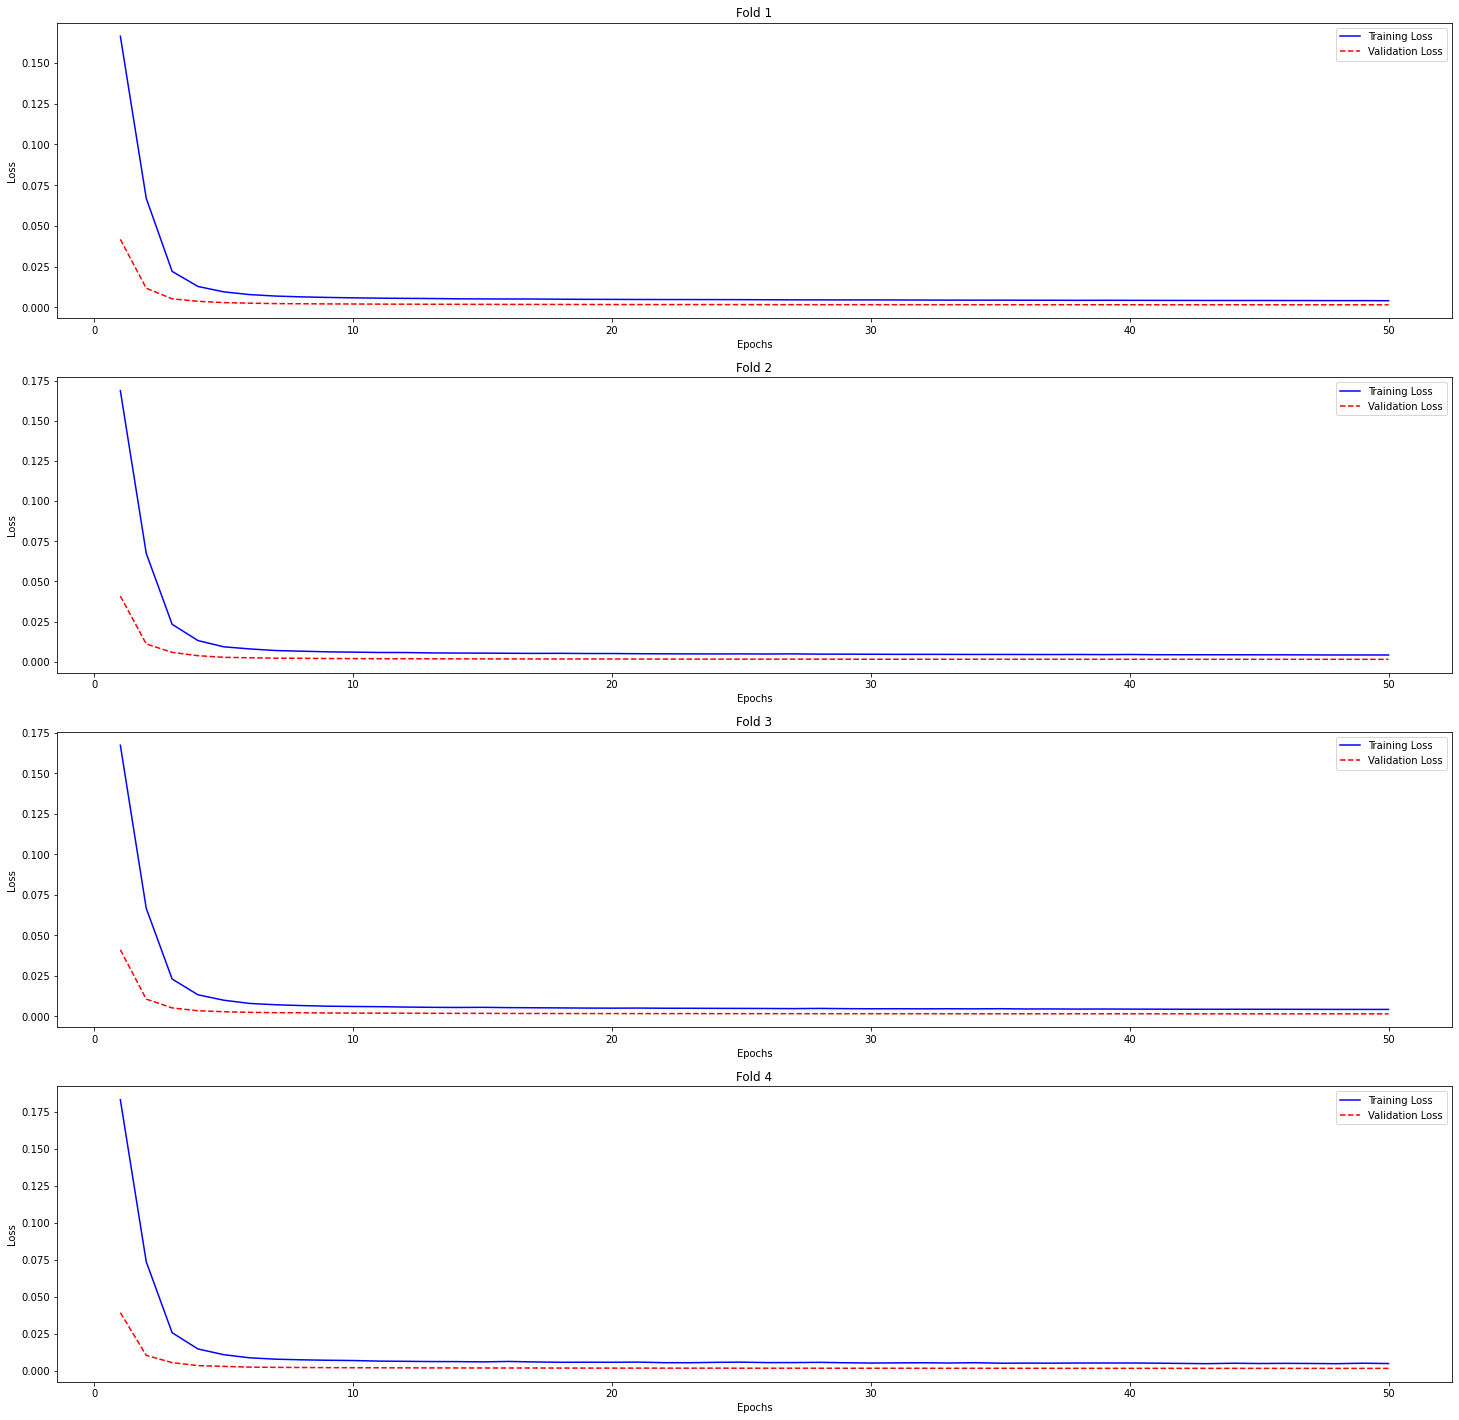

In [10]:
LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(25, 25))
for fold in range(n_folds):
    plt.subplot(n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Submission

In [11]:
X_test = ts_feat.copy()
X_test = preprocess(X_test)

sigid   = X_test.iloc[:, 0].values
X_test  = X_test.iloc[:, top_feats].values

ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, Names, ts_data)

final_data = np.concatenate((sigid.reshape(-1,1), y_pred), axis=1)

final_df = pd.DataFrame(final_data, columns=columns)
columns = columns[1:]
final_df.loc[ts_feat['cp_type']=='ctl_vehicle', columns] = 0
final_df.to_csv("./submission.csv",index=False)


------------------------------

	Evaluating ...

------------------------------

Evaluating Completed

------------------------------

